## DIBD studies with Rarefy

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from skbio.stats import subsample_counts
from biom import load_table
from gneiss.cluster import correlation_linkage
from gneiss.util import rename_internal_nodes, match
from gneiss.balances import balance_basis
from skbio.stats.composition import ilr
import skbio
import qiime2

import dsfdr
import statistics
import transform

%matplotlib notebook
import matplotlib.pyplot as plt
import pylab

In [2]:
def convert_biom_to_pandas(table):
    otu_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    return otu_table

In [138]:
table = load_table('../data/dibd.biom')
otu_table = convert_biom_to_pandas(table)

In [139]:
otu_table.shape

(181, 867)

In [140]:
# rarefy the data
# row is samples, column is features
otu_table2 = np.array(otu_table).astype(int)
otu_sum = np.sum(otu_table2, axis=1)
sp.stats.describe(otu_sum)

DescribeResult(nobs=181, minmax=(3, 33645), mean=15121.6408839779, variance=53125636.364763662, skewness=0.13030260002240623, kurtosis=-0.08688686228613829)

In [141]:
labels = np.array(otu_sum >= 1000) # minmax = (1k, 10k)
otu_table3 = otu_table2[labels==True, :]

In [142]:
otu_table_r = np.zeros(np.shape(otu_table3))
for i in range(np.shape(otu_table3)[0]):
    col_r = subsample_counts(otu_table3[i, :], 1000)
    otu_table_r[i, :] = col_r

In [143]:
otu_table_r.shape
otu_table_r = pd.DataFrame(otu_table_r)

In [144]:
# generate the tree
otu_tree = correlation_linkage(otu_table_r+1)

In [145]:
basis, _ = balance_basis(otu_tree)
balances = ilr(otu_table_r+1, basis)

In [146]:
balance_ids = [n.name for n in otu_tree.levelorder() if not n.is_tip()]
balances_df = pd.DataFrame(balances, index=otu_table.index[labels], columns=balance_ids)

In [147]:
mapping=pd.read_table("../data/dibd.map.txt", sep='\t', header=0, index_col=0)

In [148]:
mapping2 = mapping.loc[mapping['disease_stat'].isin(['IBD','healthy'])]

In [149]:
mapping2, balances_df = match(mapping2, balances_df)

In [150]:
# fix floating point error in balances output
balances_df = np.array(balances_df)
for col in range(np.shape(balances_df)[1]):
    for row in range(np.shape(balances_df)[0]):
        close = np.isclose(balances_df[row, col], balances_df[:, col])
        balances_df[close, col] = balances_df[row, col] 

In [151]:
balances_dibd = np.transpose(balances_df)
labels_dibd = np.array((mapping2['disease_stat'] == 'IBD').astype(int))

In [175]:
results1 = dsfdr.dsfdr(data = balances_dibd, labels = labels_dibd, fdr_method='dsfdr')
results2 = dsfdr.dsfdr(data = balances_dibd, labels = labels_dibd, fdr_method='bhfdr')

In [176]:
ds = np.sum(results1[0])
bh = np.sum(results2[0])
print(ds, bh, ds-bh, (ds-bh)/bh*100)

173 150 23 15.3333333333


In [177]:
pvals = results1[2]

88.9618337782


<IPython.core.display.Javascript object>


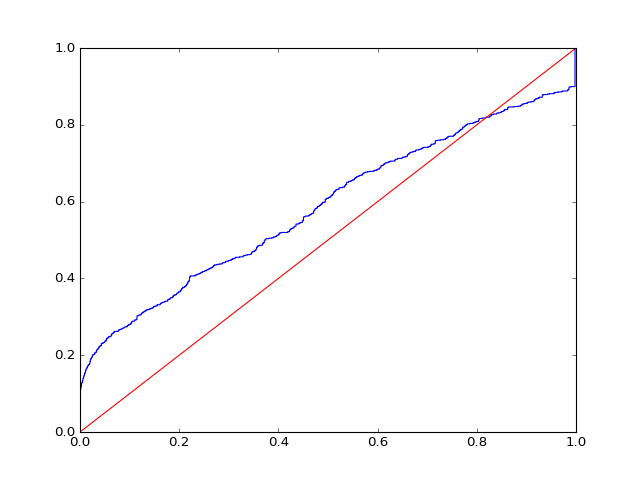

In [178]:
from statsmodels.distributions.empirical_distribution import ECDF
from numpy import linalg as LA

sample = pvals
ecdf = ECDF(sample)

x = np.sort(sample)
y = ecdf(x)
print(LA.norm(x - y, 1))

plt.figure()
plt.step(x, y)
plt.plot(x, x, color = 'red')